In [1]:
from tqdm.notebook import tqdm
import torch
import datasets
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from models import unet
import torchvision
from transformers import ToTensorTransformer

In [2]:
# train_transforms = A.Compose(
#         [
#             # A.Rotate(limit=35, p=1.0),
#             # A.HorizontalFlip(p=0.5),
#             # A.VerticalFlip(p=0.1),
#             A.Normalize(
#                 mean=[0.0],
#                 std=[1.0],
#                 max_pixel_value=255.0,
#             ),
#         ],
#     )

# val_transforms = A.Compose(
#     [
#         A.Normalize(
#             mean=[0.0],
#             std=[1.0],
#             max_pixel_value=255.0,
#         ),
#     ],
# )

to_tensor = ToTensorTransformer()


In [3]:
train_dataset = datasets.tdsc.TDSC(path_to_dataset="./data/tdsc", train=True)
validation_dataset = datasets.tdsc.TDSC(path_to_dataset="./data/tdsc", train=False)

In [29]:
x,y,l = train_dataset[0]
x = x - x*y*0.5
print(x.shape)

(128, 128, 15)


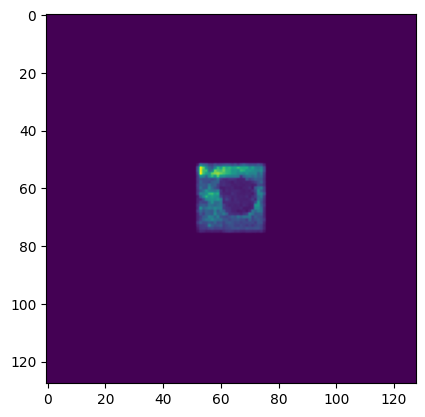

In [30]:
plt.imshow(x[:,:,7])

In [5]:

print(x.shape, y.shape)
x,y = to_tensor((x,y))
print(x.shape)

(128, 128, 15) (128, 128, 15)
torch.Size([15, 1, 128, 128])


## Building the model

In [4]:
model = unet.UNet(in_channels=1, out_channels=1)

## Dice loss

In [5]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        intersection = (predictions * targets).sum()
        dice_coefficient = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        # The Dice Loss is the complement of the Dice Coefficient
        dice_loss = 1 - dice_coefficient

        return dice_loss

## Training hyperparameters

In [6]:
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 20
# criterion = DiceLoss()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device=device)
scaler = torch.cuda.amp.GradScaler()

In [9]:
def train(model, dataset, optimizer, loss_fn):
    print("training model...")
    model.train()
    loop = tqdm(dataset)
    for data in loop:
        x, y, l = data
        # Make tumors obvious...
        x = x - x*y*0.6
        for i in range(0, x.shape[2], 32):
            inputs = x[:,:,i:i+32]
            targets = y[:,:,i:i+32]
            # make the tumors obviously visible
            inputs, targets = to_tensor((inputs, targets))
            inputs = inputs.to(device)
            targets = targets.to(device)            
            # forward
            with torch.cuda.amp.autocast():
                predictions = model(inputs)
                # predictions = torch.sigmoid(predictions)
                print(predictions.shape, inputs.shape, targets.shape)
                loss = loss_fn(predictions, targets)
            # backward
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        # update tqdm loop
        loop.set_postfix(loss=loss.item())


train(model, train_dataset, optimizer, criterion)

training model...


  0%|          | 0/80 [00:00<?, ?it/s]

torch.Size([15, 1, 128, 128]) torch.Size([15, 1, 128, 128]) torch.Size([15, 1, 128, 128])


/home/ozma/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [10]:
def calculate_accuracy(dataset, model, device="cuda"):
    
    print("calculating model accuracy...")

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    
    model.eval()
    loop = tqdm(dataset)

    with torch.no_grad():
        for vol, mask, l in loop:
            
            # Make tumors obvious...
            vol = vol-vol*mask
            vol, mask = to_tensor((vol, mask))
            
            for i in range(0, vol.shape[2], 32):
                x = vol[:,:,i:i+32]
                y = mask[:,:,i:i+32]
                x = x.to(device)
                y = y.to(device)
                preds = torch.sigmoid(model(x))
                preds = (preds > 0.5).float()
                num_correct += (preds == y).sum()
                num_pixels += torch.numel(preds)
                dice_score += (2 * (preds * y).sum()) / (
                    (preds + y).sum() + 1e-8
                )
                
            loop.set_postfix(dice_score=dice_score)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(dataset)}")
    
    model.train()

In [37]:
def save_results_as_imgs(model, dataset, path="./saved_images"):
    print("Saving the results as images...")
    model.eval()
    idx = 0
    vol, mask, label = dataset[idx]
    vol = vol - vol*mask*0.6
    vol, mask = to_tensor((vol, mask))
    vol = vol.to(device)
    mask = mask.to(device)
    print(vol.shape, mask.shape)
    
    with torch.no_grad():
        preds = torch.sigmoid(model(vol))
        preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{path}/prediction.png")
        torchvision.utils.save_image(mask, f"{path}/ground_truth.png")
    model.train()
    
save_results_as_imgs(model, validation_dataset)

Saving the results as images...
torch.Size([35, 1, 128, 128]) torch.Size([35, 1, 128, 128])


In [38]:
for i in range(num_epochs):
    train(model, train_dataset, optimizer, criterion)
    # calculate_accuracy(train_dataset, model)
    save_results_as_imgs(model, train_dataset)


training model...


  0%|          | 0/80 [00:00<?, ?it/s]

Saving the results as images...
torch.Size([15, 1, 128, 128]) torch.Size([15, 1, 128, 128])
training model...


  0%|          | 0/80 [00:00<?, ?it/s]

Saving the results as images...
torch.Size([15, 1, 128, 128]) torch.Size([15, 1, 128, 128])
training model...


  0%|          | 0/80 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
model.eval()

x, m, y = validation_dataset[10]
x, m = to_tensor((x,m))
print(x.shape)
x = x[:,10,:,:]
print(x.shape)
m = m[:,10,:,:]
x = x.unsqueeze(0)
print(x.shape)
print(m.shape)
x = x.to(device)
prediction = torch.sigmoid(model(x))
prediction = (prediction > 0.5).float()
print (prediction.shape)
pred = prediction.squeeze()
m = m.squeeze()
pred = pred.to('cpu').detach().numpy()
m = m.to('cpu').detach().numpy()
print (m.shape, pred.shape)
plt.subplot(1,2,1)
plt.imshow(pred)
plt.subplot(1,2,2)
plt.imshow(m)
plt.show()

model.train()

torch.Size([23, 1, 128, 128])


IndexError: index 10 is out of bounds for dimension 1 with size 1